In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
%matplotlib inline

In [3]:
points = np.load('/data/hok/testdata/fastsc/GM_k9_10000pts.npy')

# scikit-learn kmeans

In [4]:
from sklearn.cluster import k_means

In [5]:
%time centroids, skkm_labels, intertia = k_means(points, n_clusters=9)

CPU times: user 115 ms, sys: 1.83 ms, total: 117 ms
Wall time: 115 ms


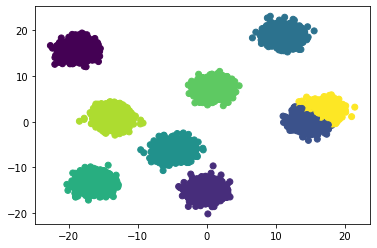

In [6]:
plt.scatter(points[:, 0], points[:, 1], c=skkm_labels)

# scikit-learn SpectralClustering

In [7]:
from sklearn.cluster import SpectralClustering

In [8]:
%time sklearn_sc = SpectralClustering(n_clusters=9, assign_labels='kmeans', random_state=0).fit(points)

CPU times: user 54.5 s, sys: 1.19 s, total: 55.6 s
Wall time: 55.7 s


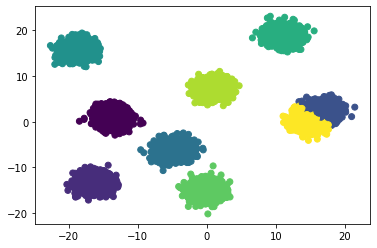

In [9]:
plt.scatter(points[:, 0], points[:, 1], c=sklearn_sc.labels_)

# SeqSC

In [10]:
from pyseqsc.seqkm import seq_sc

In [11]:
from scipy.spatial.distance import euclidean

In [12]:
%time centroids, seqsc_labels = seq_sc(points, 9, 9, euclidean, int(points.shape[0]/10))

/data/hok/conda/envs/hokdev/lib/python3.7/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1269: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  RuntimeWarning)


CPU times: user 4.39 s, sys: 137 ms, total: 4.53 s
Wall time: 4.4 s


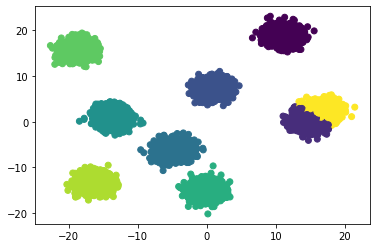

In [13]:
plt.scatter(points[:, 0], points[:, 1], c=seqsc_labels)